## Importing libraries

In [ ]:
import os
import os.path
import cv2
import glob
import imutils
from tqdm import tqdm
import pickle
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.models import load_model


# Data preprocessing


In [ ]:
counts = {}
captcha_image_folder = "captcha_images"
output_folder = "extracted_letter_images"
captcha_image_files = glob.glob(os.path.join(captcha_image_folder, "*"))
#print(captcha_image_files)


## Image preprocessing


### Here Individual letters are extracted out of captcha image and saved into folders of corresponding letters. eg: "s" letter images into "s" folder

In [ ]:
# loop over the image paths
for (i, captcha_image_file) in tqdm(enumerate(captcha_image_files)):
    #print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    #cv2.imshow("gray",gray)
    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Hack for compatibility with different OpenCV versions
    contours = contours[0]
    letter_image_regions = []

    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        #print(x,y,w,h)
        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:or
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))
    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue
    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    # Save out each letter as a single image
    #print(captcha_correct_text)
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box
        #print(letter_bounding_box)
        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        print(letter_image)
        print(letter_text)
        # Get the folder to save the image in
        save_path = os.path.join(output_folder, letter_text)
   import imutils
     #print(save_path)
        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # write the letter image to a file
        count = counts.get(letter_text, 1)
        #zfill adds zeros (0) at the beginning of the string, until it reaches the specified length.
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6))) 
        cv2.imwrite(p, letter_image)
        # increment the count for the current key
        counts[letter_text] = count + 1

# Separating dataset into train and test data . 

### Encoded the target variable using labelBinarizer and saved it 

In [ ]:
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
# initialize the data and labels
data = []
labels = []
# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= cv2.resize(image,(50,50))
    
    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)
    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    #print(label)
    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)
# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)
#print(Y_train)
# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
# scale the raw pixel intensities to the range [0, 1] (this improves training)
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

## Training ,building and saving the model

In [ ]:
# Build the neural network!
model = Sequential()
# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(50, 50, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))
# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=5, verbose=1)
# Save the trained model to disk
model.save(MODEL_FILENAME)
model.summary()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Epoch 1/5
364/364 [==============================] - 44s 120ms/step - loss: 0.2729 - accuracy: 0.9315 - val_loss: 0.0099 - val_accuracy: 0.9985
Epoch 2/5
364/364 [==============================] - 39s 107ms/step - loss: 0.0089 - accuracy: 0.9979 - val_loss: 0.0080 - val_accuracy: 0.9995
Epoch 3/5
364/364 [==============================] - 42s 114ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 5.7631e-05 - val_accuracy: 1.0000
Epoch 4/5
364/364 [==============================] - 46s 125ms/step - loss: 9.8966e-05 - accuracy: 1.0000 - val_loss: 1.6082e-05 - val_accuracy: 1.0000
Epoch 5/5
364/364 [==============================] - 43s 117ms/step - loss: 1.1018e-05 - accuracy: 1.0000 - val_loss: 8.7239e-06 - val_accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 20)        520       
                                          

# predictions using test images


### Here image preprocessing for test images.saved cnn model is used for predicting the results

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


CAPTCHA text is: N6GA


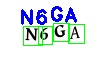

CAPTCHA text is: N6F7


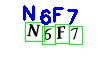

CAPTCHA text is: N6B6


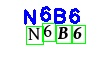

CAPTCHA text is: N6FC


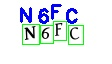

In [ ]:
#solve_captchas_with_model.py

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "captcha_test_images"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0]


    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    #print(image)
    output = cv2.merge([image] * 3)
    predictions = []
    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = cv2.resize(letter_image, (50, 50))

        # Turn the single image into a 4d list of images
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)
        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)
        #print(prediction)
        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        #print(letter)
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    #cv2.imshow("Output", output) #ERROR error: /tmp/build/80754af9/opencv_1512491966934/work/modules/highgui/src/window.cpp:611: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage
    #WORKAROUND https://stackoverflow.com/a/11855133/8800831
    cv2.imwrite('workaround.jpg',output)
    from IPython.display import Image
    display(Image(filename='workaround.jpg'))    